# Зависимость рождаемости от брачности на основе анализа временных рядов

## 1) Визуальный анализ временного ряда брачности


### 1.1 Подготовка данных по брачности

##### Импорт необходимых для дальнейшей работы библиотек

In [2]:
import pandas as pd # библиотека для работы с табличными данными
import matplotlib.pyplot as plt # библиотека для построения графиков
import matplotlib.ticker as ticker # модуль управления тиками
from statsmodels.graphics.tsaplots import plot_acf # АКФ
import statsmodels.api as sm # библиотека статистических функций 
import datetime as dt # библиотека для работы с datetime

##### Загрузка данных из csv-файла в датафрейм pandas

In [3]:
df_marriage = pd.read_csv('divorce_marriage.csv', encoding='ansi')

##### Отображение структуры полученного датафрейма

In [4]:
df_marriage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28878 entries, 0 to 28877
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   territory               28878 non-null  int64  
 1   id_indicator            28878 non-null  int64  
 2   period                  28878 non-null  object 
 3   territory.ccube.0       28878 non-null  object 
 4   territory.ccube.1       28568 non-null  object 
 5   territory.ccube.2       26112 non-null  object 
 6   territory.ccube.attr.0  28878 non-null  int64  
 7   territory.ccube.3       28878 non-null  object 
 8   territory.ccube.4       28878 non-null  object 
 9   value                   28878 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.2+ MB


    - id_indicator - это id показателя (браки = 814, разводы = 816)
    - territory.ccube.(0-2) - это идентификатор уровня субъекта (0 - страна, 1 - федеральный округ, 2 - область или округ)
##### Выбор необходимого параметра и региона

In [5]:
df_m_clean = df_marriage.loc[(df_marriage['territory.ccube.3'] == 'Орловская область') & (df_marriage['id_indicator'] == 814)].reset_index(drop=True)

##### Удаление лишних колонок

In [6]:
df_m_clean = df_m_clean.drop(["territory", "id_indicator", "territory.ccube.0", "territory.ccube.1", "territory.ccube.2", "territory.ccube.attr.0", "territory.ccube.3", "territory.ccube.4"], axis=1)

In [7]:
df_m_clean.rename(columns={'period': 'дата', 'value': 'значение'}, inplace=True)

In [8]:
df_m_clean.head()

,дата,значение
0,31 Jan 2009 00:00:00,5.16
1,28 Feb 2009 00:00:00,6.84
2,31 Mar 2009 00:00:00,5.61
3,30 Apr 2009 00:00:00,6.20
4,31 May 2009 00:00:00,5.58


##### Преобразование формата даты

In [9]:
format = '%d %b %Y %H:%M:%S'

In [10]:
df_m_clean['дата'] = df_m_clean.apply(lambda x: dt.datetime.strptime(str(x['дата']), format), axis=1)

In [11]:
new_format = '%d.%m.%Y'

In [12]:
df_m_clean['дата'] = df_m_clean.apply(lambda x: dt.datetime.strftime(x['дата'], new_format), axis=1)

In [13]:
df_m_clean.head()

,дата,значение
0,31.01.2009,5.16
1,28.02.2009,6.84
2,31.03.2009,5.61
3,30.04.2009,6.20
4,31.05.2009,5.58


### 1.2. Построение графика по брачности

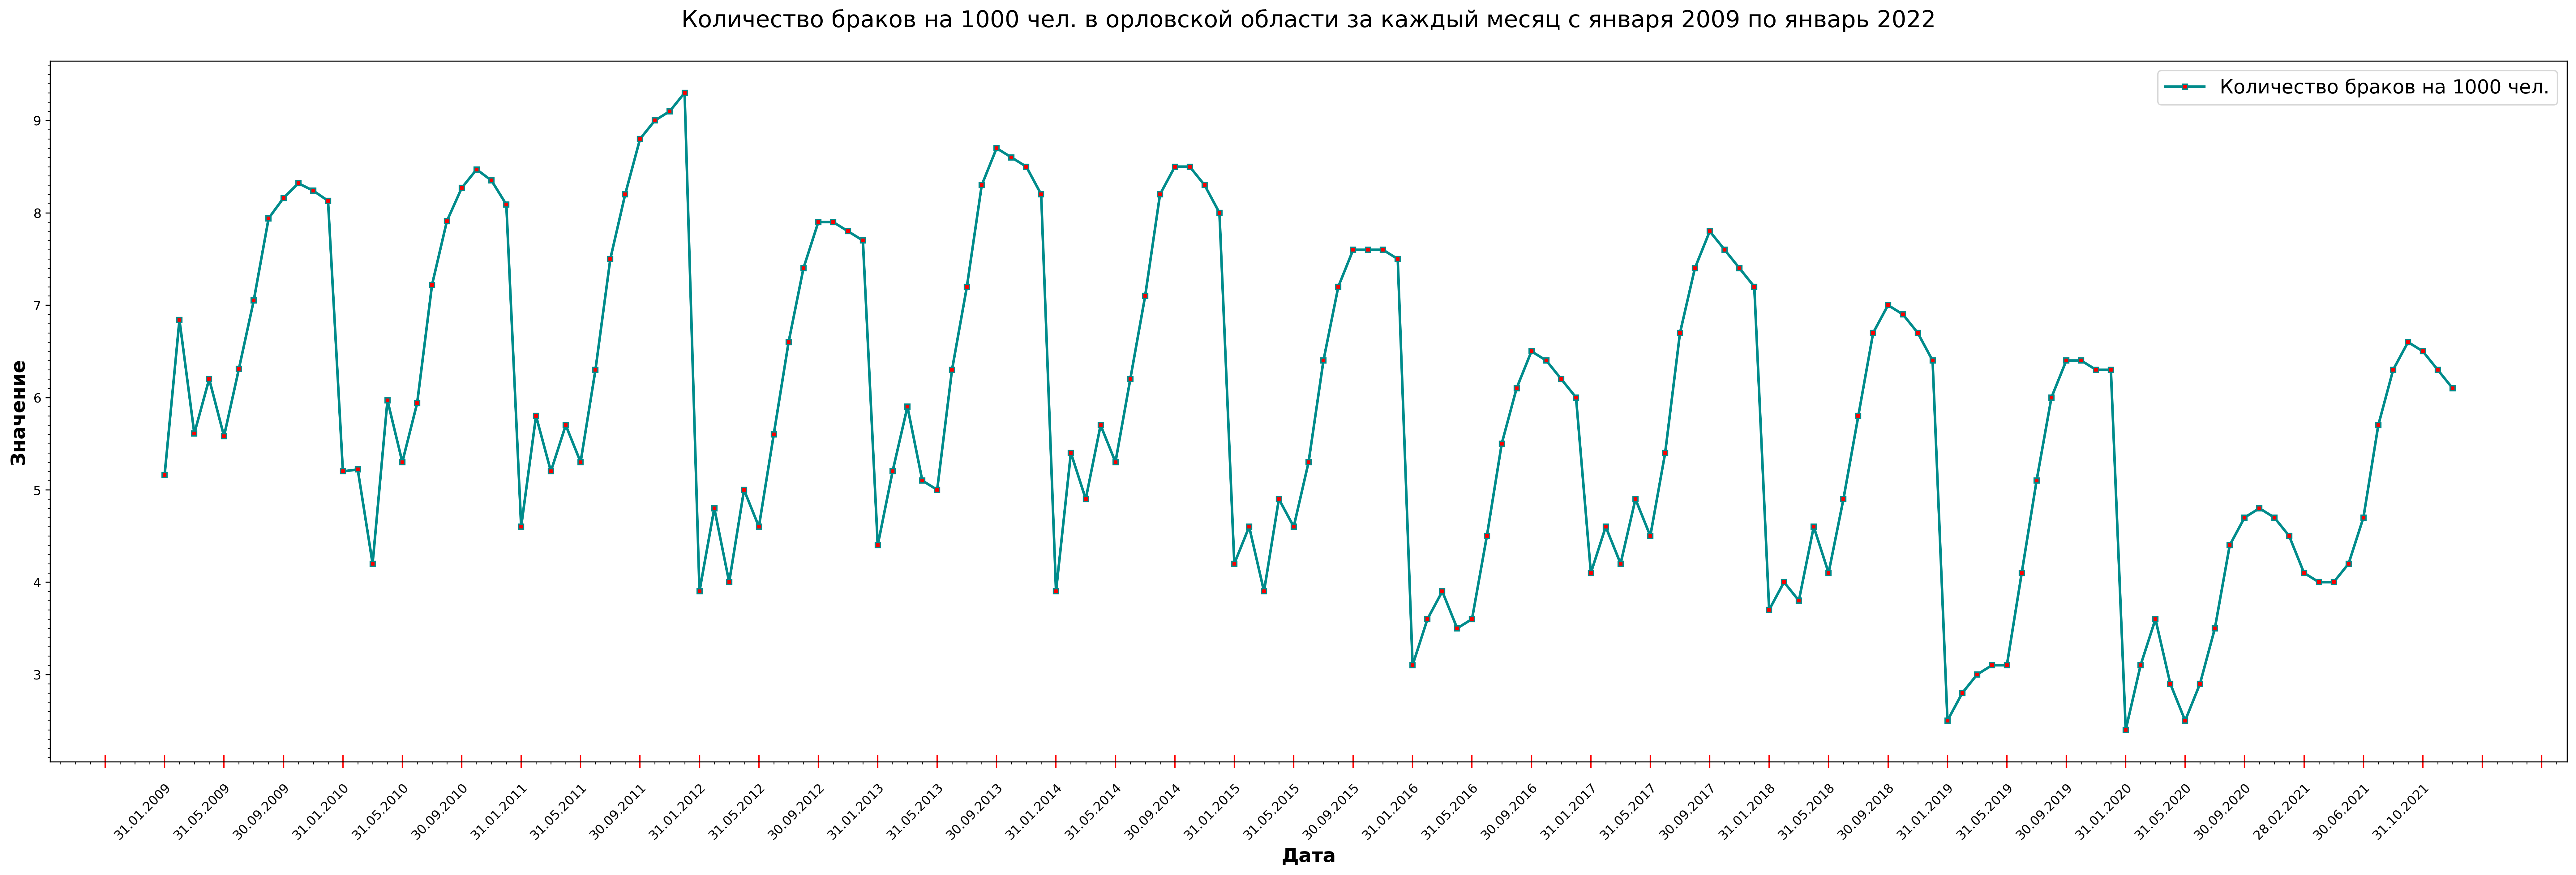

In [14]:
fig, ax = plt.subplots(dpi=300)

x = df_m_clean['дата']
y = df_m_clean['значение']

ax.plot(x, y, color='darkcyan', lw=2, ls='-', marker='s', markersize=4, markerfacecolor='red', label='Количество браков на 1000 чел.')

#  Исправление формата подписей оси x
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.legend(loc=0, prop={'size': 15})
ax.set_xlabel('Дата', fontsize=15, fontweight='bold')
ax.set_ylabel('Значение', fontsize=15, fontweight='bold')
ax.set_title('Количество браков на 1000 чел. в орловской области за каждый месяц с января 2009 по январь 2022\n',
            fontsize=18)

ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 1,     #  Ширина делений
               color = 'r',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'k',    #  Цвет подписи
               bottom = True,    #  Рисуем метки снизу
               labelbottom = True)    #  Рисуем подписи снизу

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.set_figwidth(35)
fig.set_figheight(10)

plt.show()

### 1.3 Построение графика АКФ

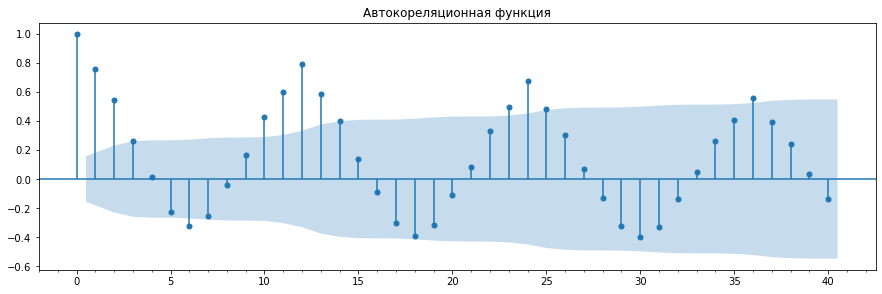

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig = sm.graphics.tsa.plot_acf(df_m_clean['значение'], lags=40, ax=ax, alpha=0.05, title='Автокореляционная функция')

##### Каждые 12 лагов достигается максимальное значение АКФ, что говорит о наличии сезонности; 

In [28]:
acf_array = sm.tsa.stattools.acf(df_m_clean['значение'], nlags=40)

In [30]:
acf_df = pd.DataFrame(acf_array, columns = ['АКФ'])

In [33]:
acf_df.head(13)

,АКФ
0,1.000000
1,0.756942
2,0.543984
3,0.258659
4,0.015323
5,-0.224296
6,-0.320759
7,-0.252316
8,-0.039436
9,0.168332


## 2) Визуальный анализ данных по рождаемости

##### Проделаем те жа шаги по подготовке данных и построению графика для данных по рождаемости

In [36]:
df_birth = pd.read_csv('birthrate.csv', encoding='ansi')

In [37]:
df_birth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15190 entries, 0 to 15189
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_indicator       15190 non-null  int64  
 1   territory          15190 non-null  int64  
 2   period             15190 non-null  object 
 3   territory.ccube.0  15190 non-null  int64  
 4   territory.ccube.1  15027 non-null  float64
 5   territory.ccube.2  13735 non-null  float64
 6   territory.ccube.3  15190 non-null  int64  
 7   territory.ccube.4  15190 non-null  int64  
 8   territory.ccube.5  15190 non-null  int64  
 9   territory.ccube.6  15190 non-null  int64  
 10  territory.ccube.7  15190 non-null  int64  
 11  value              15190 non-null  float64
dtypes: float64(3), int64(8), object(1)
memory usage: 1.4+ MB


In [44]:
df_birth['territory.ccube.6'].unique()

array([     643,       30, 14000000, 15000000, 17000000, 20000000,
       24000000, 29000000, 34000000, 38000000, 42000000, 46000000,
       54000000, 61000000, 66000000, 68000000, 28000000, 70000000,
       78000000, 45000000,       31, 86000000, 87000000,    11800,
       11000000, 19000000, 27000000, 41000000, 47000000, 49000000,
       58000000, 40000000,       37, 79000000, 85000000, 35000000,
        3000000, 12000000, 18000000, 60000000, 67000000,       38,
       82000000, 26000000, 83000000, 91000000, 90000000, 96000000,
        7000000,       33, 80000000, 88000000, 89000000, 92000000,
       94000000, 97000000, 57000000,    57800, 33000000, 22000000,
       53000000, 56000000, 36000000, 63000000, 73000000,       34,
       37000000, 65000000,    71800,    71900, 71000000, 75000000,
             35, 84000000, 93000000, 95000000,  1000000,  4000000,
        4653000,  4650000, 25000000,    25800, 32000000, 50000000,
       52000000, 69000000,       36, 81000000, 76000000,    76

## 3) Тест Дикки-Фуллера

In [11]:
import statsmodels.api as sm

In [35]:
test = sm.tsa.stattools.adfuller(df_m_clean['значение'])
print(test)

(-1.6855543395519295, 0.4385702627984426, 12, 142, {'1%': -3.477261624048995, '5%': -2.8821181874544233, '10%': -2.5777431104939494}, 271.25774092164266)
